## Application of Random Forest to Flow Data data stream

This code is based on the random forest ipython notebook generated by KJ for the October, 2021 analysis of EPRI Flow Data. The version here is meant to process the flow loop data and look for the changes to the data stream produced by physical anomalies, as indicated by the notebook provided by Lea Boche and Christina Lawson (EPRI). 

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble  import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn import tree
from sklearn.preprocessing import StandardScaler


import sys
sys.path.append('/Users/j.wagg/DataScience/S2DS/EPRI/NewData2022/Logs')
from lablog_parser import *
from custom_metric import *

pd.set_option("display.max.columns", None)

In [31]:
# reading in the flow loop data training sample 
flow_data = pd.read_csv("final.csv")
flow_data.keys()

Index(['Unnamed: 0', 'max_FIT102_Raw_Signal', 'min_FIT102_Raw_Signal',
       'mean_FIT102_Raw_Signal', 'std_FIT102_Raw_Signal',
       'max_FIT202_Raw_Signal', 'min_FIT202_Raw_Signal',
       'mean_FIT202_Raw_Signal', 'std_FIT202_Raw_Signal',
       'max_LIT101_Raw_Signal', 'min_LIT101_Raw_Signal',
       'mean_LIT101_Raw_Signal', 'std_LIT101_Raw_Signal',
       'max_LIT201_Raw_Signal', 'min_LIT201_Raw_Signal',
       'mean_LIT201_Raw_Signal', 'std_LIT201_Raw_Signal',
       'max_PIT101_Raw_Signal', 'min_PIT101_Raw_Signal',
       'mean_PIT101_Raw_Signal', 'std_PIT101_Raw_Signal',
       'max_PIT102_Raw_Signal', 'min_PIT102_Raw_Signal',
       'mean_PIT102_Raw_Signal', 'std_PIT102_Raw_Signal',
       'max_PIT201_Raw_Signal', 'min_PIT201_Raw_Signal',
       'mean_PIT201_Raw_Signal', 'std_PIT201_Raw_Signal',
       'max_PIT202_Raw_Signal', 'min_PIT202_Raw_Signal',
       'mean_PIT202_Raw_Signal', 'std_PIT202_Raw_Signal',
       'max_SI102_Raw_Signal', 'min_SI102_Raw_Signal', 'mean_SI102

In [32]:
# add a new column to the data frame so that anomalies appear as binary 1 yes/0 no anomaly
# we can then use this for the Neural Network (just convert the 'label' column)
flow_data['bin_anomaly'] = 0

for index in flow_data.index:
    if flow_data['target'][index] != 'normal':
        flow_data.at[index,'bin_anomaly'] = 1
        

## Random Forest binary approach to classification of anomalies

In [33]:
drop_list = ['Unnamed: 0','target']
             #,'std_FIT202_Raw_Signal','min_SI102_Raw_Signal','std_PIT102_Raw_Signal',
             #'min_LIT101_Raw_Signal','std_PIT101_Raw_Signal','max_SI102_Raw_Signal','max_PIT101_Raw_Signal',
             #'std_LIT101_Raw_Signal','mean_PIT202_Raw_Signal','std_FIT102_Raw_Signal','max_PIT202_Raw_Signal',
             #'mean_FIT202_Raw_Signal','min_PIT202_Raw_Signal','max_PIT102_Raw_Signal','mean_PIT201_Raw_Signal',
             #'mean_PIT102_Raw_Signal','min_PIT102_Raw_Signal','min_FIT102_Raw_Signal','min_PIT201_Raw_Signal',
             #'mean_SI102_Raw_Signal','max_LIT101_Raw_Signal','mean_FIT102_Raw_Signal','mean_SI202_Raw_Signal',
             #'max_FIT102_Raw_Signal','min_PIT101_Raw_Signal']

value = 'bin_anomaly'
print(flow_data['bin_anomaly'].describe())

count    14304.000000
mean         0.276636
std          0.447351
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: bin_anomaly, dtype: float64


In [34]:
# Begin with binary classification approach

scaler = StandardScaler()  
#drop the columns we don't need
df = flow_data.drop(drop_list, axis=1)

print(df.head())
    

#define features and value
X = df.drop(value, axis=1)
y = df[value]
    
    
#create train and test datasets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20, random_state = 100)
    
#train the model
model = RandomForestClassifier(random_state = 100)
    
model.fit(X_train,y_train)
    
    
#calculate accuracy
predict_train = model.predict(X_train)
predict_val = model.predict(X_val)
accuracy_train = accuracy_score(y_train,predict_train)
print("Accuracies")
print('accuracy_score on train dataset : ', accuracy_train)
accuracy_val = accuracy_score(y_val,predict_val)
print('accuracy_score on test dataset : ', accuracy_val)
print('\n')
    
    
#calculate feature importances
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)
print('Importances')
print(importances)
print('\n')

   max_FIT102_Raw_Signal  min_FIT102_Raw_Signal  mean_FIT102_Raw_Signal  \
0                   4.30                  -4.28               -0.248235   
1                   4.58                  -3.32                0.001176   
2                   5.10                  -3.80                0.071765   
3                   5.10                  -3.80               -0.042353   
4                   5.10                  -3.80                0.175294   

   std_FIT102_Raw_Signal  max_FIT202_Raw_Signal  min_FIT202_Raw_Signal  \
0               2.485488                   2.68                  -4.32   
1               2.543123                   2.26                  -5.88   
2               2.814365                   5.16                  -5.88   
3               2.228765                   5.16                  -5.88   
4               2.095346                   2.74                  -3.54   

   mean_FIT202_Raw_Signal  std_FIT202_Raw_Signal  max_LIT101_Raw_Signal  \
0               -0.040000    

In [35]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 100,
 'verbose': 0,
 'warm_start': False}

In [36]:
#model hypertuning

# Number of trees in random forest
n_estimators = [50,75,100]

# Number of features to consider at every split; REMEMBER TO CHANGE THIS WHEN MORE FEATURES ARE PRESENT
max_features = [1,2,5,10,12,15,20]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 50]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the grid
search_params = {'n_estimators': n_estimators,
                 'max_features': max_features,
                 'min_samples_split': min_samples_split,
                 'bootstrap': bootstrap}

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=100)

#perform model hypertuning

model_v2 = GridSearchCV(model, search_params, cv=cv, n_jobs=-1)

model_v2.fit(X_train, y_train)

best_params = model_v2.best_params_

print('Best Parameters: ', model_v2.best_params_)

print('Best score: ', model_v2.best_score_)

Best Parameters:  {'bootstrap': False, 'max_features': 12, 'min_samples_split': 2, 'n_estimators': 75}
Best score:  0.938007863695937


In [37]:
#train the hypetuned model

model_v3 = RandomForestClassifier(random_state = 100, bootstrap = 'False', min_samples_split=2, max_features=12, n_estimators = 75)
model_v3.fit(X_train, y_train)

#perform cross validation
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=100)
scores = cross_val_score(model_v3, X, y, cv=cv, n_jobs=-1)
 
print('Cross Validation accuracy scores: %s' % scores)
 
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Cross Validation accuracy scores: [0.94442503 0.93953163 0.93184201 0.93883258 0.92694862 0.92764768
 0.92974484 0.93184201 0.93673541 0.92869626]
Cross Validation accuracy: 0.934 +/- 0.006


In [38]:
#perform cross validation
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=100)
scores = cross_val_score(model_v3, X, y, cv=cv, n_jobs=-1, scoring=make_scorer(cedric_metric_binary, greater_is_better=True))
 
print('Cross Validation accuracy scores: %s' % scores)
 
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Cross Validation accuracy scores: [1.48004651e-37 2.93758821e-38 9.58158595e-45 1.03900395e-45
 3.57863658e-51 4.38858202e-50 1.35050787e-47 8.33985681e-45
 9.08982245e-44 1.87427817e-45]
Cross Validation accuracy: 0.000 +/- 0.000


Importances
                   feature  importance
13   min_LIT201_Raw_Signal       0.086
18  mean_PIT101_Raw_Signal       0.079
14  mean_LIT201_Raw_Signal       0.073
10  mean_LIT101_Raw_Signal       0.064
15   std_LIT201_Raw_Signal       0.060
39    std_SI202_Raw_Signal       0.052
36    max_SI202_Raw_Signal       0.034
37    min_SI202_Raw_Signal       0.031
35    std_SI102_Raw_Signal       0.027
12   max_LIT201_Raw_Signal       0.026
31   std_PIT202_Raw_Signal       0.024
5    min_FIT202_Raw_Signal       0.022
4    max_FIT202_Raw_Signal       0.020
24   max_PIT201_Raw_Signal       0.020
16   max_PIT101_Raw_Signal       0.019
9    min_LIT101_Raw_Signal       0.019
23   std_PIT102_Raw_Signal       0.018
33    min_SI102_Raw_Signal       0.018
32    max_SI102_Raw_Signal       0.018
30  mean_PIT202_Raw_Signal       0.017
7    std_FIT202_Raw_Signal       0.016
27   std_PIT201_Raw_Signal       0.016
28   max_PIT202_Raw_Signal       0.015
6   mean_FIT202_Raw_Signal       0.015
11   std_LIT1

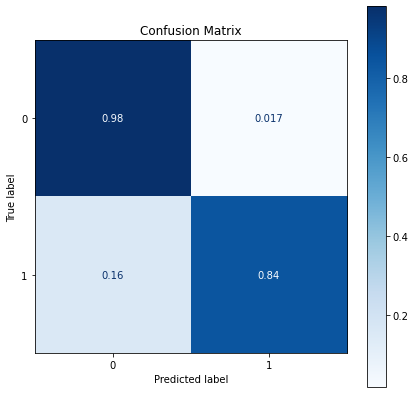

In [39]:
#calculate feature importances
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(model_v3.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)
print('Importances')
print(importances)
print('\n')  
    
#print classification report
print('Classification report')
predict_val = model_v3.predict(X_val)
print(classification_report(y_val, predict_val))
print('\n')
    
#print normalized confusion matrix   
matrix = plot_confusion_matrix(model_v3, X_val, y_val, cmap=plt.cm.Blues, normalize='true')
matrix.ax_.set_title('Confusion Matrix')
fig = plt.gcf()
fig.set_size_inches(7, 7)
plt.show()